In [1]:
%load_ext tensorboard
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

import tensorflow_datasets as tfds

In [2]:
INPUT_SHAPE = (512,1024,3)
NUM_CLASSES = 2
SCALE = 2
OUTPUT_SHAPE = ((INPUT_SHAPE[0] // 8) * SCALE, (INPUT_SHAPE[1] // 8) * SCALE, NUM_CLASSES)

def ge_layer(x_in, c, e=6, stride=1):
    x = layers.Conv2D(filters=c, kernel_size=(3,3), padding='same')(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    if stride == 2:
        x = layers.DepthwiseConv2D(depth_multiplier=e, kernel_size=(3,3), strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        y = layers.DepthwiseConv2D(depth_multiplier=e, kernel_size=(3,3), strides=2, padding='same')(x_in)
        y = layers.BatchNormalization()(y)
        y = layers.Conv2D(filters=c, kernel_size=(1,1), padding='same')(y)
        y = layers.BatchNormalization()(y)
    else:
        y = x_in
        
    x = layers.DepthwiseConv2D(depth_multiplier=e, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=c, kernel_size=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, y])
    x = layers.Activation('relu')(x)
    return x


def stem(x_in, c):
    x = layers.Conv2D(filters=c, kernel_size=(3,3), strides=2, padding='same')(x_in)
    x = layers.BatchNormalization()(x)
    x_split = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=c / 2, kernel_size=(1,1), padding='same')(x_split)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=c, kernel_size=(3,3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    y = layers.MaxPooling2D()(x_split)
    
    x = layers.Concatenate()([x, y])
    x = layers.Conv2D(filters=c, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

def detail_conv2d(x_in, c, stride=1):
    x = layers.Conv2D(filters=c, kernel_size=(3,3), strides=stride, padding='same')(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

def context_embedding(x_in, c):
    x = layers.GlobalAveragePooling2D()(x_in)
    x = layers.BatchNormalization()(x)
    
    x = layers.Reshape((1,1,c))(x)
    
    x = layers.Conv2D(filters=c, kernel_size=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = tf.broadcast_to(x, tf.shape(x_in))
    # broadcast
    
    x = layers.Add()([x, x_in])
    x = layers.Conv2D(filters=c, kernel_size=(3,3), padding='same')(x)
    return x

def bilateral_guided_aggregation(detail, semantic, c):
    #print(f'detail shape: {detail.shape}')
    #print(f'semantic shape: {semantic.shape}')
    
    # detail branch
    detail_a = layers.DepthwiseConv2D(kernel_size=(3,3), padding='same')(detail)
    detail_a = layers.BatchNormalization()(detail_a)
    
    detail_a = layers.Conv2D(filters=c, kernel_size=(1,1), padding='same')(detail_a)
    
    detail_b = layers.Conv2D(filters=c, kernel_size=(3,3), strides=2, padding='same')(detail)
    detail_b = layers.BatchNormalization()(detail_b)
    
    detail_b = layers.AveragePooling2D((3,3), strides=2, padding='same')(detail_b)
    
    # semantic branch
    semantic_a = layers.DepthwiseConv2D(kernel_size=(3,3), padding='same')(semantic)
    semantic_a = layers.BatchNormalization()(semantic_a)
    
    semantic_a = layers.Conv2D(filters=c, kernel_size=(1,1), padding='same')(semantic_a)
    semantic_a = layers.Activation('sigmoid')(semantic_a)
    
    semantic_b = layers.Conv2D(filters=c, kernel_size=(3,3), padding='same')(semantic)
    semantic_b = layers.BatchNormalization()(semantic_b)
    
    semantic_b = layers.UpSampling2D((4,4), interpolation='bilinear')(semantic_b)
    semantic_b = layers.Activation('sigmoid')(semantic_b)
    
    # combining
    detail = layers.Multiply()([detail_a, semantic_b])
    semantic = layers.Multiply()([semantic_a, detail_b])
    
    # this layer is not mentioned in the paper !?
    semantic = layers.UpSampling2D((4,4))(semantic)
    
    x = layers.Add()([detail, semantic])
    x = layers.Conv2D(filters=c, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    return x

def seg_head(x_in, c_t, s, n):
    x = layers.Conv2D(filters=c_t, kernel_size=(3,3), padding='same')(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=n, kernel_size=(3,3), padding='same')(x)
    x = layers.UpSampling2D((s,s), interpolation='bilinear')(x)
    
    return x

x_in = layers.Input(INPUT_SHAPE)

# semantic branch
x = stem(x_in, 16)
x = ge_layer(x, 32, stride=2)
x = ge_layer(x, 32, stride=1)

x = ge_layer(x, 64, stride=2)
x = ge_layer(x, 64, stride=1)

x = ge_layer(x, 128, stride=2)

x = ge_layer(x, 128, stride=1)
x = ge_layer(x, 128, stride=1)
x = ge_layer(x, 128, stride=1)

x = context_embedding(x, 128)

# detail branch
y = detail_conv2d(x_in, 64, stride=2)
y = detail_conv2d(y, 64, stride=1)

y = detail_conv2d(y, 64, stride=2)
y = detail_conv2d(y, 64, stride=1)
y = detail_conv2d(y, 64, stride=1)

y = detail_conv2d(y, 128, stride=2)
y = detail_conv2d(y, 128, stride=1)
y = detail_conv2d(y, 128, stride=1)

x = bilateral_guided_aggregation(y, x, 128)

x = seg_head(x, 128, 2, NUM_CLASSES)


In [3]:
m = models.Model(inputs=[x_in], outputs=[x])

In [4]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
m.compile(optimizers.SGD(momentum=0.9), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [6]:
cityscapes = tfds.load('cityscapes/semantic_segmentation')

In [7]:
def prep_data(sample):
    img = sample['image_left']
    seg = sample['segmentation_label']
    
    img /= 255
    
    img = tf.image.resize(img, INPUT_SHAPE[0:2])
    seg = tf.image.resize(seg, OUTPUT_SHAPE[0:2])
    
    # map class 0=anything, 1=road
    # or use to_categorical for all classes
    seg = tf.where(seg == 7, [0,1], [1,0])
    
    return img, seg

train_ds = cityscapes['train'].map(prep_data)
valid_ds = cityscapes['validation'].map(prep_data)

In [8]:
def display_segmentation(pred):
    img = tf.argmax(pred, axis=-1)
    img = img[..., tf.newaxis]
    return tf.keras.preprocessing.image.array_to_img(img)

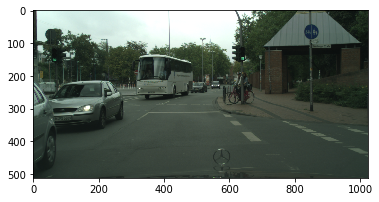

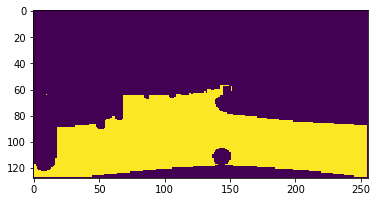

In [9]:
example = list(valid_ds.take(1))[0]
plt.imshow(example[0])
plt.show()

plt.imshow(display_segmentation(example[1]))

In [10]:
BATCH_SIZE = 4

train_ds = train_ds.batch(BATCH_SIZE).prefetch(100)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(100)

In [11]:
EPOCHS = 10

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = m.fit(train_ds,
                validation_data=valid_ds,
                epochs=EPOCHS,
                callbacks=[tensorboard_callback])

Epoch 1/10
744/744 [==============================] - 453s 581ms/step - loss: 0.5609 - accuracy: 0.7843 - val_loss: 0.8289 - val_accuracy: 0.6758
Epoch 2/10
744/744 [==============================] - 421s 565ms/step - loss: 0.2621 - accuracy: 0.8956 - val_loss: 0.3320 - val_accuracy: 0.8358
Epoch 3/10
744/744 [==============================] - 434s 582ms/step - loss: 0.2210 - accuracy: 0.9132 - val_loss: 0.2123 - val_accuracy: 0.9178
Epoch 4/10
744/744 [==============================] - 419s 562ms/step - loss: 0.2120 - accuracy: 0.9236 - val_loss: 0.1889 - val_accuracy: 0.9245
Epoch 5/10
744/744 [==============================] - 426s 571ms/step - loss: 0.1597 - accuracy: 0.9365 - val_loss: 0.2678 - val_accuracy: 0.9096
Epoch 6/10
744/744 [==============================] - 431s 579ms/step - loss: 0.1540 - accuracy: 0.9413 - val_loss: 0.2346 - val_accuracy: 0.9208
Epoch 7/10
744/744 [==============================] - 425s 570ms/step - loss: 0.1697 - accuracy: 0.9395 - val_loss: 0.1873 -

In [12]:
m.save('model.tf')

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


In [13]:
test_ds = cityscapes['test'].map(prep_data)

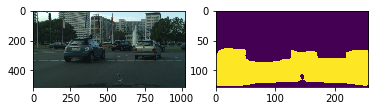

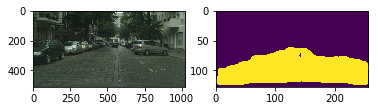

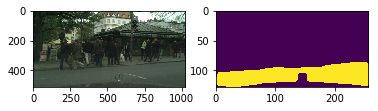

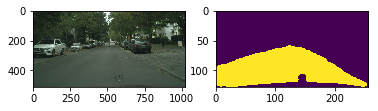

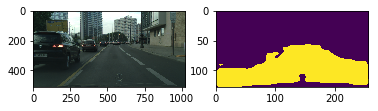

In [24]:
for sample in test_ds.take(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    pred = m.predict(tf.expand_dims(sample[0], axis=0))[0]
    ax1.imshow(sample[0])
    ax2.imshow(display_segmentation(pred))

In [25]:
def representative_dataset():
    for data in test_ds.batch(1):
        yield [data[0]]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('model.tf')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

with open('model_quant.tflite', 'wb') as fd:
    fd.write(tflite_quant_model)
